# Combining ice data

For this project we have multiple ice datasets. This notebook is used to combine them to a new dataset:

    Antarctic Ice Concentration (AIC)
    
The Land ice data comes from this source and is explained well at this [link](https://grace.jpl.nasa.gov/data/monthly-mass-grids/)

[data source](https://podaac.jpl.nasa.gov/dataset/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2?ids=Collections:Availability&values=GRACE%20RL06:DELAY_MODE)

First let's start by loading our relevant module. 

In [1]:
from modules import combine_ice as ci
from modules import week5 as w5
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# autoreload so I can easily modify the code without running this cell repetitively
%load_ext autoreload
%autoreload 2

Let's inspect the two datasets

In [2]:
SIC = ci.load_seaice()
# SIC

In [3]:
LIC = ci.load_landice()
LIC = LIC.sel(lat=slice(-90,-55))

Our first problem here is that the units in each dataset are different. This is because they are measuring different things.

The sea ice data is measuring concentration of sea ice by measuring the albedo of different ocean regions. Where the albedo is high we associate this with more ice. 
Whereas the land ice data is measuring the mass of liquid water equivilent (LWE). The unit used is m as the researchers using this associate the thickness of LWE with its mass.

To overcome this, we will normalise each dataset at each gridpoint so our units become standard deviations of change.

In [4]:
LIC = ci.latlon_to_polarstereo(LIC)

C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\hjel867\AppData\Local\Continuum\anaconda3\envs\Antarctica_2\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=

In [5]:
import xarray as xr
IC = SIC.fillna(LIC)

Ice = xr.Dataset(dict(SIC=SIC, LIC=LIC
                        ))

In [6]:
# Ice = (Ice.sel(time=slice('2002-01-01','2019-12-31'))
#       .pipe(w5.find_anomalies)
#       .pipe(w5.yearly_average)
#       .pipe(w5.normalise_indepenant)


In [7]:
import matplotlib.pyplot as plt

AttributeError: 'DataArray' object has no attribute 'nanmean'

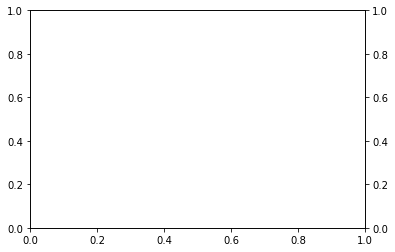

In [12]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
# ax.plot(Ice.IC.time,Ice.IC.mean(dim=('x','y')), label='Total Ice', lw=3)
l1 = ax.plot(Ice.SIC.time,Ice.SIC.mean(dim=('x','y')), label='Sea Ice')
ax2.plot([],[])
l2 = ax2.plot(Ice.LIC.time,Ice.LIC.mean(dim=('x','y')), label='Land Ice')
lines = l1 + l2
labels = [line.get_label() for line in lines]
ax.legend(lines, labels)
plt.savefig('images/week7/ice_timeseries.pdf')
plt.show()

In [9]:
SIC_trends = SIC.polyfit(dim='time', deg=1).sel(degree=1).polyfit_coefficients * 1e9*60*60*24*365
SIC_trends = SIC_trends.where(abs(SIC_trends) != 0.0)

LIC_trends = LIC.polyfit(dim='time', deg=1).sel(degree=1).polyfit_coefficients * 1e9*60*60*24*365
LIC_trends = LIC_trends.where(abs(LIC_trends) != 0.0)

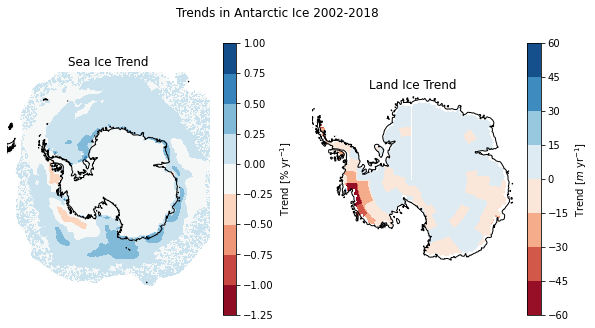

In [10]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121, projection = ccrs.SouthPolarStereo())
contor = ax.contourf(SIC_trends.x, SIC_trends.y, 100/250 *SIC_trends.values, cmap = 'RdBu', transform=ccrs.SouthPolarStereo())
ax.coastlines()
ax.set_axis_off()
cbar = plt.colorbar(contor)
cbar.set_label('Trend [$\%$ yr$^{-1}$]')
ax.set_title('Sea Ice Trend')

ax = fig.add_subplot(122, projection = ccrs.SouthPolarStereo())
contor = ax.contourf(LIC_trends.x, LIC_trends.y, LIC_trends.values, cmap = 'RdBu', transform=ccrs.SouthPolarStereo())
ax.coastlines()
ax.set_axis_off()
cbar = plt.colorbar(contor)
cbar.set_label('Trend [$m$ yr$^{-1}$]')
ax.set_title('Land Ice Trend')
fig.suptitle('Trends in Antarctic Ice 2002-2018')
plt.savefig('images/week7/ice_trends.pdf')

Text(0.5, 1.0, 'Combined Ice Trend')

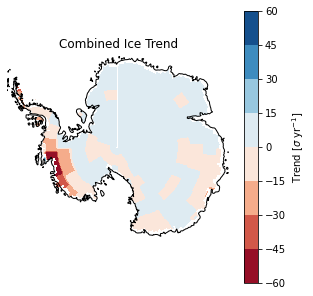

In [11]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection = ccrs.SouthPolarStereo())
contor = ax.contourf(SIC_trends.x, SIC_trends.y, SIC_trends.values+LIC_trends.values, cmap = 'RdBu', transform=ccrs.SouthPolarStereo())
ax.coastlines()
ax.set_axis_off()
cbar = plt.colorbar(contor)
cbar.set_label('Trend [$\sigma$ yr$^{-1}$]')
ax.set_title('Combined Ice Trend')